In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Dataset.csv to Dataset.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DataTrain_with_features_2.csv to DataTrain_with_features_2.csv


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.5 MB/s eta 0:00:00


In [ ]:
!pip install tldextract dnspython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 11.4 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import time
import re
import socket
import tldextract
import dns.resolver
import math
from urllib.parse import urlparse
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
df_tune = pd.read_csv('Dataset.csv')
df_test = pd.read_csv('DataTrain_with_features_2.csv')

In [ ]:
df_tune.shape

(247950, 42)

In [ ]:
df_test.shape

(65226, 43)

In [ ]:
# Chỉ lấy các cột đặc trưng và nhãn từ cùng một DataFrame
X_tune = df_tune.iloc[:, 1:]
y_tune = df_tune['label']

print(X_tune.shape, y_tune.shape)

(247950, 41) (247950,)


In [ ]:
X_test = df_test.iloc[:, 2:]
y_test = df_test['label']

print(X_test.shape, y_test.shape)

(65226, 41) (65226,)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_tune, y_tune, test_size=0.2, stratify=y_tune, random_state=42
)

In [ ]:
#Mới
rf_test = RandomForestClassifier(n_estimators=1000,
                                 max_depth=100,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 bootstrap=False,
                                 max_features='log2',
                                 class_weight='balanced',
                                 random_state=42,
                                 n_jobs=-1
                                 )
start_time = time.time()
rf_test.fit(X_train, y_train)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian huấn luyện: {elapsed_time_ms:.2f} ms")

Thời gian huấn luyện: 479561.02 ms


In [ ]:
y_pred = rf_test.predict(X_valid)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

# Ma trận nhầm lẫn
print("\nConfusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

Accuracy: 0.9665860052429925

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     25708
           1       0.97      0.96      0.97     23882

    accuracy                           0.97     49590
   macro avg       0.97      0.97      0.97     49590
weighted avg       0.97      0.97      0.97     49590


Confusion Matrix:
[[24973   735]
 [  922 22960]]


In [ ]:
y_pred = rf_test.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Ma trận nhầm lẫn
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8497071719866311

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     32613
           1       0.80      0.93      0.86     32613

    accuracy                           0.85     65226
   macro avg       0.86      0.85      0.85     65226
weighted avg       0.86      0.85      0.85     65226


Confusion Matrix:
[[25073  7540]
 [ 2263 30350]]


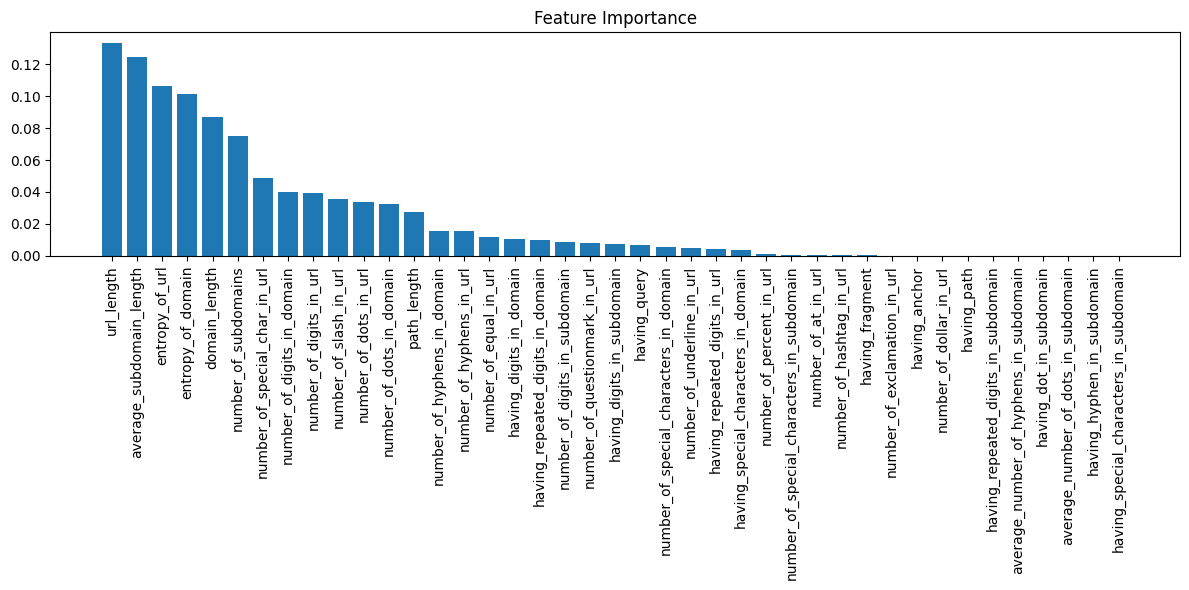

Top 3 Features quan trọng nhất:
url_length: 0.1333
average_subdomain_length: 0.1244
entropy_of_url: 0.1063


In [ ]:
# Trực quan hóa Feature Importance
importances = rf_test.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_tune.columns

plt.figure(figsize=(12,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# In ra 3 đặc trưng quan trọng nhất
top_3_features = [feature_names[i] for i in indices[:3]]
top_3_importances = importances[indices[:3]]

print("Top 3 Features quan trọng nhất:")
for i in range(3):
    print(f"{top_3_features[i]}: {top_3_importances[i]:.4f}")

In [ ]:
# Tách Features từ tập raw dataset
def calculate_entropy(string):
    prob = [float(string.count(c)) / len(string) for c in set(string)]
    return -sum(p * math.log2(p) for p in prob)

def extract_features_from_url(url):
    features = {}
    parsed = urlparse(url)
    ext = tldextract.extract(url)

    domain = ext.registered_domain or ''
    subdomain = ext.subdomain or ''
    path = parsed.path or ''
    query = parsed.query or ''
    fragment = parsed.fragment or ''

    sub_parts = subdomain.split('.') if subdomain else []

    # 1. URL_based Features
    features['url_length'] = len(url)
    features['number_of_dots_in_url'] = url.count('.')
    features['having_repeated_digits_in_url'] = int(bool(re.search(r'(\d)\1', url)))
    features['number_of_digits_in_url'] = sum(c.isdigit() for c in url)
    features['number_of_special_char_in_url'] = len(re.findall(r'[^\w]', url))
    features['number_of_hyphens_in_url'] = url.count('-')
    features['number_of_underline_in_url'] = url.count('_')
    features['number_of_slash_in_url'] = url.count('/')
    features['number_of_questionmark_in_url'] = url.count('?')
    features['number_of_equal_in_url'] = url.count('=')
    features['number_of_at_in_url'] = url.count('@')
    features['number_of_dollar_in_url'] = url.count('$')
    features['number_of_exclamation_in_url'] = url.count('!')
    features['number_of_hashtag_in_url'] = url.count('#')
    features['number_of_percent_in_url'] = url.count('%')

    # 2. Domain_based Features
    features['domain_length'] = len(domain)
    features['number_of_dots_in_domain'] = domain.count('.')
    features['number_of_hyphens_in_domain'] = domain.count('-')
    features['having_special_characters_in_domain'] = int(bool(re.search(r'[^\w\.]', domain)))
    features['number_of_special_characters_in_domain'] = len(re.findall(r'[^\w\.]', domain))
    features['having_digits_in_domain'] = int(any(c.isdigit() for c in domain))
    features['number_of_digits_in_domain'] = sum(c.isdigit() for c in domain)
    features['having_repeated_digits_in_domain'] = int(bool(re.search(r'(\d)\1', domain)))

    # 3. Subdomain_based Features
    features['number_of_subdomains'] = len(sub_parts)
    features['having_dot_in_subdomain'] = int('.' in subdomain)
    features['having_hyphen_in_subdomain'] = int('-' in subdomain)
    features['average_subdomain_length'] = np.mean([len(p) for p in sub_parts]) if sub_parts else 0
    features['average_number_of_dots_in_subdomain'] = np.mean([s.count('.') for s in sub_parts]) if sub_parts else 0
    features['average_number_of_hyphens_in_subdomain'] = np.mean([s.count('-') for s in sub_parts]) if sub_parts else 0
    features['having_special_characters_in_subdomain'] = int(bool(re.search(r'[^\w\.]', subdomain)))
    features['number_of_special_characters_in_subdomain'] = len(re.findall(r'[^\w\.]', subdomain))
    features['having_digits_in_subdomain'] = int(any(c.isdigit() for c in subdomain))
    features['number_of_digits_in_subdomain'] = sum(c.isdigit() for c in subdomain)
    features['having_repeated_digits_in_subdomain'] = int(bool(re.search(r'(\d)\1', subdomain)))

    # 4. Other Features
    features['having_path'] = int(bool(path))
    features['path_length'] = len(path)
    features['having_query'] = int(bool(query))
    features['having_fragment'] = int(bool(fragment))
    features['having_anchor'] = int('#' in url)
    features['entropy_of_url'] = calculate_entropy(url)
    features['entropy_of_domain'] = calculate_entropy(domain)

    return features


In [ ]:
model_input_columns = X_train.columns.tolist()

In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://emiratespass-online.com/mb/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = rf_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 231.13 ms
Phishing


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://allegrolokalnie.id-798144.sbs")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = rf_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 329.61 ms
Phishing


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://e-zpassny.com-ezoz.vip/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = rf_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 241.00 ms
Legit


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://www.facebook.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = rf_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 252.04 ms
Legit


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://www.instagram.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = rf_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 241.96 ms
Legit


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://www.youtube.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = rf_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 227.31 ms
Legit


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://gamebanana.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = rf_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 266.50 ms
Legit


In [ ]:
xgb_test = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=100,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=0.929,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
xgb_test.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    verbose=False
)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian huấn luyện: {elapsed_time_ms:.2f} ms")

Thời gian huấn luyện: 104050.17 ms


In [ ]:
y_pred = xgb_test.predict(X_valid)

acc = accuracy_score(y_valid, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

# Ma trận nhầm lẫn
print("\nConfusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

Accuracy: 96.62%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     25708
           1       0.97      0.96      0.96     23882

    accuracy                           0.97     49590
   macro avg       0.97      0.97      0.97     49590
weighted avg       0.97      0.97      0.97     49590


Confusion Matrix:
[[24973   735]
 [  940 22942]]


In [ ]:
y_pred = xgb_test.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Ma trận nhầm lẫn
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 92.55%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     32613
           1       0.90      0.96      0.93     32613

    accuracy                           0.93     65226
   macro avg       0.93      0.93      0.93     65226
weighted avg       0.93      0.93      0.93     65226


Confusion Matrix:
[[28980  3633]
 [ 1227 31386]]


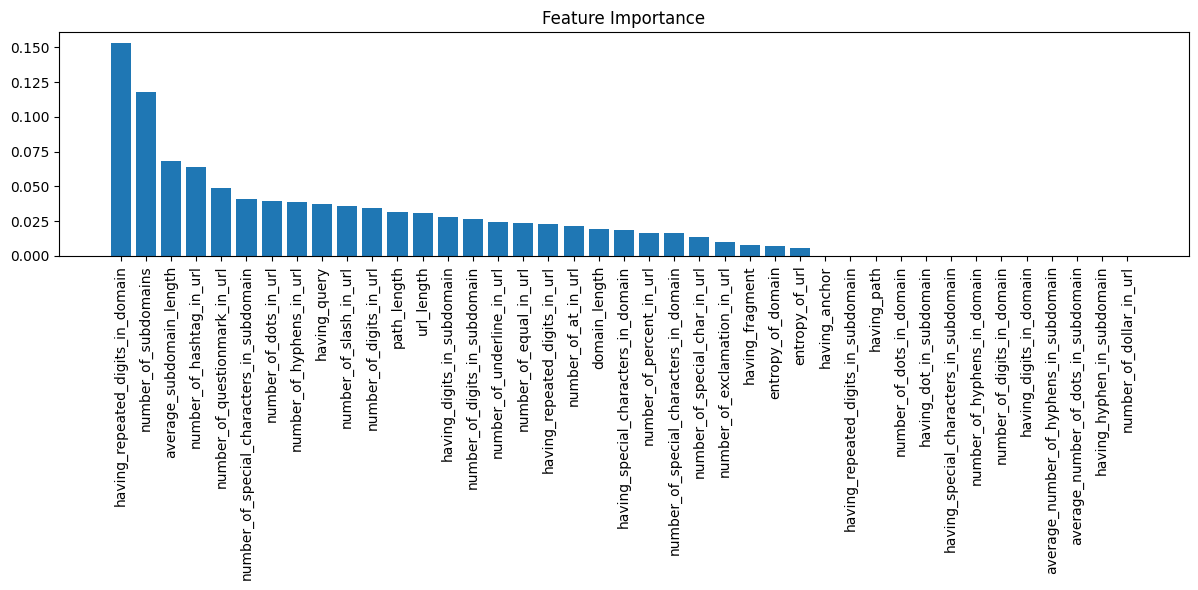

Top 3 Features quan trọng nhất:
having_repeated_digits_in_domain: 0.1531
number_of_subdomains: 0.1176
average_subdomain_length: 0.0678


In [ ]:
# Trực quan hóa Feature Importance
importances = xgb_test.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_tune.columns

plt.figure(figsize=(12,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# In ra 3 đặc trưng quan trọng nhất
top_3_features = [feature_names[i] for i in indices[:3]]
top_3_importances = importances[indices[:3]]

print("Top 3 Features quan trọng nhất:")
for i in range(3):
    print(f"{top_3_features[i]}: {top_3_importances[i]:.4f}")

In [ ]:
model_input_columns = X_train.columns.tolist()

In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://emiratespass-online.com/mb/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 20.33 ms
Phishing


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://etcaer.xin/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 57.43 ms
Phishing


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://e-zpassny.com-ezoz.vip/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 28.13 ms
Phishing


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://www.facebook.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 21.16 ms
Legit


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://www.instagram.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 25.34 ms
Legit


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://www.youtube.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 24.24 ms
Legit


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://ctt.hust.edu.vn/#")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 48.89 ms
Phishing
